In [86]:
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import math

####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)
    # Sample and convert sentence.  
    print('')
    for j in range(3):
        emission, states = hmm.generate_emission(24)
        sentence = [obs_map_r[j] for j in emission]
        sentence = ' '. join(sentence).capitalize()
        words = sentence.split()
        threecount = int(math.ceil(len(words)/6.0))
        for i in range(threecount):
            if i == 3:
                print(' '.join(words[i*6:(i+1)*6]) + '.')
            else:
                print(' '.join(words[i*6:(i+1)*6]) + ',')
    emission, states = hmm.generate_emission(12)
    sentence = [obs_map_r[j] for j in emission]
    sentence = ' '. join(sentence).capitalize()
    words = sentence.split()
    threecount = int(math.ceil(len(words)/6.0))
    for i in range(threecount):
        if i == 1:
            print('    ' + ' '.join(words[i*6:(i+1)*6]) + '.')
        else:
            print('    ' + ' '.join(words[i*6:(i+1)*6]) + ',')
            
####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

    # honestly this function is so jank but who even fuckin cares
    # i don't even remember how or why i wrote this mess
    # no one's gonna read this
    # hey if you see this tho hmu on fb let's be friends


In [28]:
import random
import operator
import numpy as np

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''
        print("reached")
        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]
        
        # initialize the first row
        for i in range(self.L):
            probs[1][i] = self.A_start[i] * self.O[i][x[0]]
            seqs[1][i] = "" + str(i)
        for i in range(1, M): 
            for j in range(0, self.L): 
                max_ind = 0
                # initial probability 
                max_prob = probs[i][0] * self.A[0][j] * self.O[j][x[i]]
                # iterates through all the states and finds the max prob
                for t in range(1, self.L): 
                    prob = probs[i][t] * self.A[t][j] * self.O[j][x[i]]
                    if max_prob < prob: 
                        max_ind = t
                        max_prob = prob
                # sets prob array at this state and row to max prob
                probs[i+1][j] = max_prob
                # updates seqs
                seqs[i+1][j] = seqs[i][max_ind] + str(j)
        # finds the maximum prob and index at the Mth row 
        maxind, maxprob = max(enumerate(probs[M]), key =operator.itemgetter(1))
        # adds seq
        max_seq = '' + seqs[len(probs)-1][maxind] + str(maxind)
        return max_seq

    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        # if normalize is True 
        if (normalize): 
            M = len(x)      # Length of sequence.
            alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]
            # initialize first state 
            for i in range(self.L):
                alphas[1][i] = self.A_start[i] * self.O[i][x[0]]
            # for each row 
            for r in range(1, M): 
                # for each column 
                for c in range(self.L): 
                    # create an array that contains the sum for each column 
                    sum_arr = []
                    # compute sum for each column 
                    for t in range(self.L): 
                        sum_arr.append(alphas[r][t] * self.A[t][c] * self.O[c][x[r]])
                    # make the value at this specific state and row equal to the sum of the sum_arr
                    alphas[r+1][c] = sum(sum_arr)
                # compute normalization constant 
                # equal to the sum of each row in alpha 
                normalize_const = sum(alphas[r+1])
                # divide each value in the current row by this constant 
                for j in range(self.L): 
                    alphas[r+1][j] /= normalize_const
            return alphas 
        # if normalize is False 
        else: 
            M = len(x)      # Length of sequence.
            alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]
            #initilize the first state
            for i in range(self.L):
                alphas[1][i] = self.O[i][x[0]] * self.A_start[i]
            # for each ro w
            for r in range(1, M): 
                # for each column 
                for c in range(self.L): 
                    # create an array that contains the sum for each column 
                    sum_arr = []
                    # compute the sum for each column 
                    for t in range(self.L): 
                        sum_arr.append(alphas[r][t] * self.A[t][c] * self.O[c][x[r]])
                    # make the value at this specific state and row equal to the sum of the sum_arr
                    alphas[r+1][c] = sum(sum_arr)
        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        if (normalize): 
            # initialize first state 
            for i in range(self.L):
                betas[M][i] = 1
            # for each row 
            for r in range(M, 1, -1): 
                # for each column 
                for c in range(self.L): 
                    # compute sum for each column 
                    for t in range(self.L): 
                        betas[r-1][c] += betas[r][t] * self.A[c][t]*self.O[t][x[r-1]]
                # compute normalization constant 
                # equal to the sum of each row in alpha 
                normalize_const = sum(betas[r-1])
                # divide each value in the current row by this constant 
                for j in range(self.L): 
                    betas[r-1][j] /= normalize_const
            return betas
        # if normalize is False 
        else: 
            # initialize first state 
            for i in range(self.L):
                betas[M][i] = 1
            # for each row 
            for r in range(M, 1, -1): 
                # for each column 
                for c in range(self.L): 
                    # compute sum for each column 
                    for t in range(self.L): 
                        betas[r-1][c] += betas[r][t] * self.A[c][t]*self.O[t][x[r-1]]
        return betas

    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for a in range(self.L): 
            for b in range(self.L): 
                n = 0
                d = 0
                for i in range(len(X)): 
                    for j in range(1, len(X[i])): 
                        if Y[i][j-1] == a: 
                            d += 1
                            if Y[i][j] == b: 
                                n += 1
                self.A[a][b] = n/d 

        # Calculate each element of O using the M-step formulas.

        for w in range(len(self.O)): 
            for z in range(len(self.O[0])): 
                n = 0 
                d = 0 
                for i in range(len(X)): 
                    for j in range(len(X[i])): 
                        if Y[i][j] == w: 
                            d += 1
                            if X[i][j] == z: 
                                n += 1
                    self.O[w][z] = n/d


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        for epoch in range(N_iters): 
            print("iteration: ", epoch)
            O_numerator = np.zeros([self.L, self.D])
            O_denominator = np.zeros([self.L, 1])
            A_numerator = np.zeros([self.L, self.L])
            A_denominator = np.zeros([self.L, 1])

            for seq in X: 
                alphas = self.forward(seq, normalize=True)
                betas = self.backward(seq, normalize=True)
                M = len(seq)

                for j in range(1, M+1): 
                    gamma = []
                    sum_gamma = 0
                    for a in range(0, self.L): 
                        sum_gamma += alphas[j][a] * betas[j][a]
                        gamma.append(alphas[j][a] * betas[j][a])
                    gamma = np.copy(gamma)
                    gamma = np.divide(gamma, sum_gamma)

                    for a in range(self.L): 
                        if j != M: 
                            A_denominator[a] += gamma[a]
                        O_numerator[a][seq[j-1]] += gamma[a]
                        O_denominator[a] += gamma[a]

                for j in range(1, M): 
                    arr = np.zeros([self.L, self.L])
                    for a in range(self.L): 
                        for b in range(self.L): 
                            arr[a][b] += alphas[j][a] * self.O[b][seq[j]] * self.A[a][b] * betas[j+1][b]
                    
                    sum_normal = 0
                    for i in range(self.L):
                        for j in range(self.L):  
                            sum_normal += arr[i][j]
                    for i in range(self.L): 
                        for j in range(self.L): 
                            arr[i][j] /= sum_normal
                    for a in range(self.L): 
                        for b in range(self.L): 
                            A_numerator[a][b] += arr[a][b]

            self.A = np.divide(A_numerator, A_denominator)
            self.O = np.divide(O_numerator, O_denominator)
    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''
        emission = []
        states = []
        r = np.random.choice(self.L, 1)

        for i in range(M): 
            Y_sum = sum(self.A[r[0]])
            X_sum = sum(self.O[r[0]])
            Y_prob = np.divide(self.A[r[0]], Y_sum)
            X_prob = np.divide(self.O[r[0]], X_sum)
            Y_random = np.random.choice(self.L, 1, p = Y_prob)
            X_random = np.random.choice(self.D, 1, p = X_prob)

            emission.append(X_random[0])
            states.append(Y_random[0])
            r = np.random.choice(self.L, 1)
        return emission, states

    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.

        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.

        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)
    random.seed(2019)
    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM


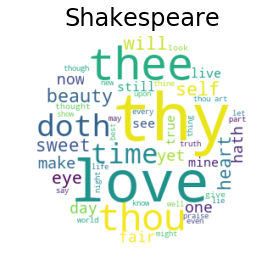

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4

Sample Sentence: 2 states

I a by me the vex,
win unlearned reckoned upon scythe boy,
decay need my deny star look,
space in sweet and away my.
Thy that in found nor expressed,
as the truth thy their purposed,
such there before love to every,
bath till mind for would may.
And o sorrow my have say,
state to of be vice to,
not april do partly my these,
beshrew tell thou thou you her.
    Unknown no in this angry and,
    him acceptable being no my these.


"\nhmm8 = unsupervised_HMM(obs, 10, 100)\nprint('\nSample Sentence: 10 state\n====================')\nprint(sample_sentence(hmm8, obs_map, n_words=25))\n\nhmm1 = unsupervised_HMM(obs, 1, 100)\nprint('\nSample Sentence: 1 state\n====================')\nprint(sample_sentence(hmm1, obs_map, n_words=25))\n\nhmm4 = unsupervised_HMM(obs, 4, 100)\nprint('\nSample Sentence: 4 states\n====================')\nprint(sample_sentence(hmm4, obs_map, n_words=25))\n\nhmm16 = unsupervised_HMM(obs, 16, 100)\nprint('\nSample Sentence: 16 states\n====================')\nprint(sample_sentence(hmm16, obs_map, n_words=25))"

In [87]:
import os
import numpy as np
from IPython.display import HTML

text = open(os.path.join(os.getcwd(), '/Users/Netra/Documents/Caltech2ndYear/2ndTerm/CS155/HW/MiniProject3/project3/data/shakespeare.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

obs, obs_map = parse_observations(text)
hmm2 = unsupervised_HMM(obs, 2, 5)
print('\nSample Sentence: 2 states\n====================')
sample_sentence(hmm2, obs_map, n_words=25)

'''
hmm8 = unsupervised_HMM(obs, 10, 100)
print('\nSample Sentence: 10 state\n====================')
print(sample_sentence(hmm8, obs_map, n_words=25))

hmm1 = unsupervised_HMM(obs, 1, 100)
print('\nSample Sentence: 1 state\n====================')
print(sample_sentence(hmm1, obs_map, n_words=25))

hmm4 = unsupervised_HMM(obs, 4, 100)
print('\nSample Sentence: 4 states\n====================')
print(sample_sentence(hmm4, obs_map, n_words=25))

hmm16 = unsupervised_HMM(obs, 16, 100)
print('\nSample Sentence: 16 states\n====================')
print(sample_sentence(hmm16, obs_map, n_words=25))'''